In [2]:
# Cell 1: Import libraries and set up environment
# This cell imports libraries for data handling, image processing, model building, and ensures reproducibility.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and random seeds set!")


✅ Libraries imported and random seeds set!


In [3]:
# Cell 2: Load dataset metadata and perform train-val-test split
# This cell reads the CSV files, merges them, and splits into train, val, and test sets to avoid data leakage.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

print("Total records in full dataset:", len(labels_simple))

# 1) Split off test set (15%)
train_val_df, test_df = train_test_split(labels_simple, test_size=0.15,
                                         random_state=SEED, stratify=labels_simple['Target'])
# 2) Split remaining 85% into train (70%) and val (15%)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765,  # 15% of total
                                    random_state=SEED, stratify=train_val_df['Target'])

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))


Total records in full dataset: 26684
Train samples: 18677
Validation samples: 4004
Test samples: 4003


In [4]:
# Cell 3: Define image loading and preprocessing
# This cell defines a function to load a DICOM file, normalize pixel values, and resize the image to (224,224).
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize to (224, 224)
    img_resized = cv2.resize(img_norm, img_size)
    # Add channel dimension for grayscale
    img_resized = np.expand_dims(img_resized, axis=-1)
    return img_resized

# Test the function on a sample
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape:", sample_img.shape)


✅ Sample image shape: (224, 224, 1)


In [5]:
# Cell 3: Define image loading and preprocessing
# This cell defines a function to load a DICOM file, normalize pixel values, and resize the image to (224,224).
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize to (224, 224)
    img_resized = cv2.resize(img_norm, img_size)
    # Add channel dimension for grayscale
    img_resized = np.expand_dims(img_resized, axis=-1)
    return img_resized

# Test the function on a sample
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape:", sample_img.shape)


✅ Sample image shape: (224, 224, 1)


In [6]:
# Cell 4: Define data augmentation (optional)
# This cell uses TensorFlow's tf.image operations to augment images on-the-fly for the training set.
def augment_image(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label


In [7]:
# Cell 5: Create data generators for train, val, and test
# This cell builds tf.data.Dataset pipelines. For the training dataset, we use .repeat() and .shuffle().

def data_generator(df, batch_size=32, img_size=(224, 224), repeat=False, augment=False):
    def gen():
        for _, row in df.iterrows():
            patient_id = row['patientId']
            label = 1 if row['Target'] == 'Pneumonia' else 0
            dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
            img = load_preprocess_dicom(dicom_path, img_size)
            yield img, label
    
    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 1), ())
    )
    if repeat:
        ds = ds.repeat()  # ensures infinite data stream for training
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # For training: shuffle, batch, prefetch
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64

train_ds = data_generator(train_df, batch_size=BATCH_SIZE, repeat=True, augment=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, repeat=False, augment=False)
test_ds = data_generator(test_df, batch_size=BATCH_SIZE, repeat=False, augment=False)

print("Datasets created with batch size:", BATCH_SIZE)


Datasets created with batch size: 64


In [8]:
# Cell 6: Build the CNN model
# This cell defines a simple CNN with an explicit Input layer for grayscale images (224,224,1).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 7: Handle class imbalance with class weights
# This cell computes weights inversely proportional to class frequencies.
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(weights)}

print("Class Weights:", class_weights)


Class Weights: {0: 0.6454143340935794, 1: 2.2192252851711025}


In [10]:
# Cell 8: Define callbacks
# We increase patience to avoid stopping too early, and we reduce the LR when val_loss stops improving.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("Callbacks defined with increased patience to prevent early stop.")


Callbacks defined with increased patience to prevent early stop.


In [11]:
# Cell 9: Train the CNN model with steps_per_epoch and class weights
# This cell trains the model using the training dataset and validates on the validation dataset.
import math

EPOCHS = 10
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # Full pass over training data
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 292
Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.6261 - loss: 0.6778 - val_accuracy: 0.7380 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


292/292 ━━━━━━━━━━━━━━━━━━━━ 249s 856ms/step - accuracy: 0.7146 - loss: 0.5701 - val_accuracy: 0.7395 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 256s 880ms/step - accuracy: 0.7300 - loss: 0.5573 - val_accuracy: 0.7120 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.7199 - loss: 0.5561
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
292/292 ━━━━━━━━━━━━━━━━━━━━ 256s 879ms/step - accuracy: 0.7199 - loss: 0.5561 - val_accuracy: 0.7120 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 246s 846ms/step - accuracy: 0.7326 - loss: 0.5410 - val_accuracy: 0.7128 - val_loss: 0.5870 - learning_rate: 5.0000e-04
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 226s 778ms/step - accuracy: 0.7356 - loss: 0.5318 - val_accuracy: 0.7428 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 230s 789ms/step - accuracy: 0.

In [12]:
# Cell 10: Evaluate on validation and test sets
# This cell checks performance on both val and test sets to ensure no data leakage and a final unbiased metric.

# Validation Evaluation
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Test Evaluation (true final metric)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 528ms/step - accuracy: 0.7374 - loss: 0.5430
Validation Loss: 0.5397, Validation Accuracy: 0.7428
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 948ms/step - accuracy: 0.7413 - loss: 0.5374
Test Loss: 0.5324, Test Accuracy: 0.7462


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

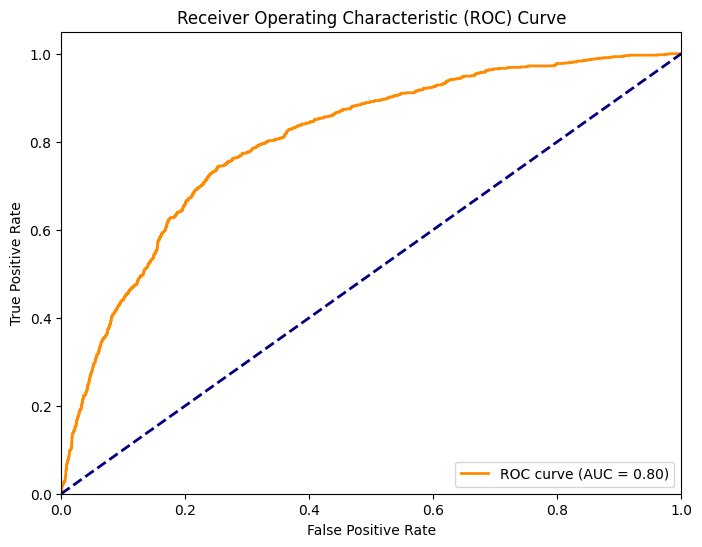

In [13]:
# Cell 11: Optional threshold tuning and additional metrics
# This cell computes precision, recall, F1, confusion matrix, and plots the ROC curve. 
# You can adjust the classification threshold to improve recall.

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

def evaluate_model(dataset, threshold=0.5):
    y_true, y_pred, y_scores = [], [], []
    for images, labels in dataset:
        preds = model.predict(images)
        y_scores.extend(preds.flatten())
        y_true.extend(labels.numpy())
        y_pred.extend((preds > threshold).astype("int32").flatten())
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

# Evaluate on test set
y_true, y_pred, y_scores = evaluate_model(test_ds, threshold=0.5)

cm = confusion_matrix(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:\n", cm)
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(rec))
print("F1-Score: {:.2f}".format(f1))
print("AUC: {:.2f}".format(roc_auc))

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


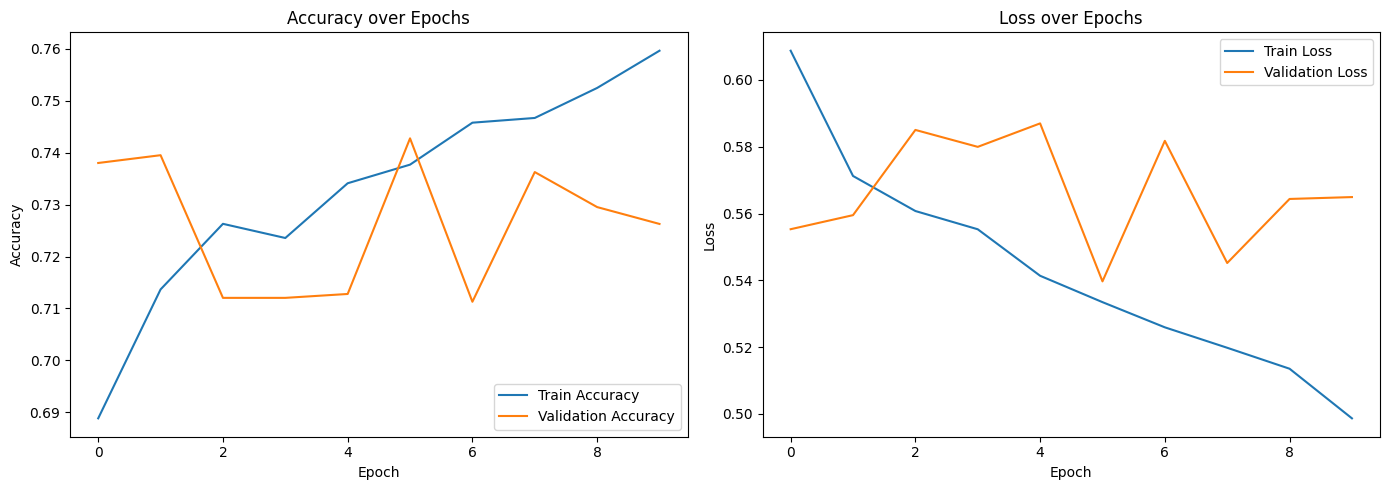

In [14]:
# Code to draw the learning curve for loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
